# Import and settings

In [412]:
import torch #基本モジュール
from torch.autograd import Variable #自動微分用
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torch.utils.data #データセット読み込み関連
import torchvision #画像関連
from torchvision import datasets, models, transforms #画像用データセット諸々

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold

from tqdm import tqdm

import logging
import logzero
from logzero import logger


# examination settings
batch_size = 128
test_batch_size = batch_size * 2
epochs = 1000
lr = 0.5
momentum = 0.9
seed = 2017
log_interval = 1000
num_workers = 2
use_gpu = False
ex_name = 'supervised'

# set seed for reproducibility
torch.manual_seed(seed)
np.random.seed(seed)

# logger setting
LOG_FORMAT = '[%(asctime)s %(levelname)s] %(message)s'
logzero.loglevel(logging.INFO)
logzero.logfile('./log/{}.log'.format(ex_name))
logzero.formatter(logging.Formatter(LOG_FORMAT))

# Prepare data

In [413]:
train_dataset = datasets.MNIST('./data/MNIST/train/', download=True, train=True)
test_dataset = datasets.MNIST('./data/MNIST/test/', download=True, train=False)

train_data = train_dataset.train_data.numpy()
test_data = test_dataset.test_data.numpy()
train_labels = train_dataset.train_labels.numpy()
test_labels = test_dataset.test_labels.numpy()

In [414]:
print(len(train_labels), len(test_labels))

60000 10000


## Change the ratio train/test
train:val:test を 800:200:69000に設定。各クラスのサンプル数は均一に。testセットは実際に教師なし学習に用いることは想定しづらいので、現実のタスクや論文に書く時はunlabeledデータとして説明すれば良い。その場合はtestセット内で更に unlabeled/holdout に分ける必要がある。
交差検証は行わない。

pseudo label実験に対してはtestデータはunlabeledデータ及び最終評価用のデータとして使われる。valは学習中の精度監視用。

In [415]:
n_train = 1000
n_val = 1000
n_test = 68000

X_train = np.empty(shape=(0, 28, 28))
y_train = np.empty(shape=(0,))
X_val = np.empty(shape=(0, 28, 28))
y_val = np.empty(shape=(0,))
X_test = np.empty(shape=(0, 28, 28))
y_test = np.empty(shape=(0,))

for i in range(10):
    idx_train = np.argwhere(train_labels == i)[:(n_train//10)].squeeze()
    idx_val = np.argwhere(train_labels == i)[(n_train//10):((n_train+n_val)//10)].squeeze()
    idx_test = np.argwhere(train_labels == i)[((n_train+n_val)//10):].squeeze()
    
    X_train = np.concatenate([X_train, train_data[idx_train]], axis=0)
    y_train = np.concatenate([y_train, train_labels[idx_train]], axis=0)
    X_val = np.concatenate([X_val, train_data[idx_val]], axis=0)
    y_val = np.concatenate([y_val, train_labels[idx_val]], axis=0)
    X_test = np.concatenate([X_test, train_data[idx_test]], axis=0)
    y_test = np.concatenate([y_test, train_labels[idx_test]], axis=0)
    
X_test = np.concatenate([X_test, test_data], axis=0)
y_test = np.concatenate([y_test, test_labels], axis=0)

# treat as image
X_train = np.expand_dims(X_train, -1)
X_val = np.expand_dims(X_val, -1)
X_test = np.expand_dims(X_test, -1)

# one-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_val = lb.transform(y_val)
y_test = lb.transform(y_test)

In [416]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(1000, 28, 28, 1) (1000, 10) (1000, 28, 28, 1) (1000, 10) (68000, 28, 28, 1) (68000, 10)


# Define a network

In [417]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.bn2(self.conv2(x)), 2))
        x = F.adaptive_avg_pool2d(x, output_size=1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x)
        return x

# Define Dataset, DataLoader

In [418]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __getitem__(self, index):
        img = self.X[index]
        img = self.transform(img)
        target = torch.Tensor(self.y[index].astype(float))
        return img, target
    
    def __len__(self):
        return self.X.shape[0]
    

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = MNISTDataset(X_train, y_train, transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_dataset = MNISTDataset(X_val, y_val, transform)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=test_batch_size, num_workers=num_workers)
test_dataset = MNISTDataset(X_test, y_test, transform)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=test_batch_size, num_workers=num_workers)

# Define TrainingTracker

In [419]:
class TrainingTracker(object):
    def __init__(self):
        self.epoch = 0
        self.history = {
            'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []
        }
        self.reset()
        
    def reset(self):
        self.train_acc = 0
        self.train_loss = 0
        self.val_acc = 0
        self.val_loss = 0
        self.train_count = 0
        self.val_count = 0

    def update(self, train, acc, loss, n):
        if train:
            acc_sum = self.train_acc * self.train_count + acc * n
            loss_sum = self.train_loss * self.train_count + loss * n
            self.train_count += n
            self.train_acc = acc_sum / self.train_count
            self.train_loss = loss_sum / self.train_count
        else:
            acc_sum = self.val_acc * self.val_count + acc * n
            loss_sum = self.val_loss * self.val_count + loss * n
            self.val_count += n
            self.val_acc = acc_sum / self.val_count
            self.val_loss = loss_sum / self.val_count

    def plot_history(self):
        plt.plot(self.history['train_acc'])
        plt.plot(self.history['val_acc'])
        plt.title('model accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(['train_acc', 'val_acc'], loc='lower right')
        plt.show()

        plt.plot(self.history['train_loss'])
        plt.plot(self.history['val_loss'])
        plt.title('model loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(['train_loss', 'val_loss'], loc='lower right')
        plt.show()

# Define train, validate, test function

In [432]:
def _train(model, data_loader, criterion, optimizer, tracker):
    model.train()
    for i, (X, y) in enumerate(data_loader):
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output = model(X)
        loss = criterion(output, y)
        pred = output.data.max(1)[1]
        answer = y.data.max(1)[1]
        acc = pred.eq(answer).sum() / len(X)
        tracker.update(train=True, acc=acc, loss=loss.data[0], n=len(X))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    logger.info(
        'Epoch: {tracker.epoch} | '
        'TrainAcc: {tracker.train_acc:.4f} | '
        'TrainLoss: {tracker.train_loss:.4f}'.format(
            tracker=tracker)
    )
    tracker.history['train_acc'].append(tracker.train_acc)
    tracker.history['train_loss'] .append(tracker.train_loss)
    tracker.reset()

def _validate(model, data_loader, criterion, tracker):
    model.eval()
    for i, (X, y) in enumerate(data_loader):
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output = model(X)
        loss = criterion(output, y)
        pred = output.data.max(1)[1]
        answer = y.data.max(1)[1]
        acc = pred.eq(answer).sum() / len(X)
        tracker.update(train=False, acc=acc, loss=loss.data[0], n=len(X))

    logger.info(
        'Epoch: {tracker.epoch} | '
        'ValAcc: {tracker.val_acc:.4f} | '
        'ValLoss: {tracker.val_loss:.4f} \n'.format(
            tracker=tracker)
    )
    tracker.history['val_acc'].append(tracker.val_acc)
    tracker.history['val_loss'].append(tracker.val_loss)
    tracker.reset()
    
def _test(model, data_loader, criterion, make_pl=False):
    model.eval()
    
    if make_pl:
        pseudo_label = np.empty((0, 10))
    
    acc_sum = 0
    loss_sum = 0
    for i, (X, y) in tqdm(enumerate(data_loader), total=len(data_loader)):
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output = model(X)
        loss = criterion(output, y)
        pred = output.data.max(1)[1]
        answer = y.data.max(1)[1]
        acc_sum += pred.eq(answer).sum()
        loss_sum += loss.data[0] * X.size(0)
        
        if make_pl:
            pseudo_label = np.concatenate([pseudo_label, output.data.numpy()], axis=0)

    acc = acc_sum / n_test
    loss = loss_sum / n_test
    logger.info(
        'TestAcc: {0:.4f} |'
        'TestLoss: {1:.4f} '.format(
            acc, loss)
    )
    
    if make_pl:
        np.save('./save/pseudo_label.npy', pseudo_label)

# Do training

[2017-12-02 05:08:22,959 INFO] Epoch: 0 | TrainAcc: 0.1040 | TrainLoss: 0.2303
[2017-12-02 05:08:23,282 INFO] Epoch: 0 | ValAcc: 0.1400 | ValLoss: 0.2300 

[2017-12-02 05:08:23,915 INFO] Epoch: 1 | TrainAcc: 0.1640 | TrainLoss: 0.2267
[2017-12-02 05:08:24,218 INFO] Epoch: 1 | ValAcc: 0.1320 | ValLoss: 0.2282 

[2017-12-02 05:08:24,868 INFO] Epoch: 2 | TrainAcc: 0.2400 | TrainLoss: 0.2234
[2017-12-02 05:08:25,173 INFO] Epoch: 2 | ValAcc: 0.2360 | ValLoss: 0.2242 

[2017-12-02 05:08:25,892 INFO] Epoch: 3 | TrainAcc: 0.3260 | TrainLoss: 0.2190
[2017-12-02 05:08:26,222 INFO] Epoch: 3 | ValAcc: 0.3310 | ValLoss: 0.2188 

[2017-12-02 05:08:26,897 INFO] Epoch: 4 | TrainAcc: 0.3710 | TrainLoss: 0.2132
[2017-12-02 05:08:27,214 INFO] Epoch: 4 | ValAcc: 0.3200 | ValLoss: 0.2125 

[2017-12-02 05:08:27,879 INFO] Epoch: 5 | TrainAcc: 0.3230 | TrainLoss: 0.2061
[2017-12-02 05:08:28,186 INFO] Epoch: 5 | ValAcc: 0.3030 | ValLoss: 0.2038 

[2017-12-02 05:08:28,920 INFO] Epoch: 6 | TrainAcc: 0.3670 | Tra

[2017-12-02 05:09:14,422 INFO] Epoch: 52 | TrainAcc: 0.9550 | TrainLoss: 0.0253
[2017-12-02 05:09:14,772 INFO] Epoch: 52 | ValAcc: 0.7910 | ValLoss: 0.0634 

[2017-12-02 05:09:15,508 INFO] Epoch: 53 | TrainAcc: 0.9490 | TrainLoss: 0.0244
[2017-12-02 05:09:15,819 INFO] Epoch: 53 | ValAcc: 0.6840 | ValLoss: 0.0895 

[2017-12-02 05:09:16,487 INFO] Epoch: 54 | TrainAcc: 0.9560 | TrainLoss: 0.0239
[2017-12-02 05:09:16,817 INFO] Epoch: 54 | ValAcc: 0.6080 | ValLoss: 0.1142 

[2017-12-02 05:09:17,492 INFO] Epoch: 55 | TrainAcc: 0.9580 | TrainLoss: 0.0218
[2017-12-02 05:09:17,804 INFO] Epoch: 55 | ValAcc: 0.6060 | ValLoss: 0.1199 

[2017-12-02 05:09:18,445 INFO] Epoch: 56 | TrainAcc: 0.9630 | TrainLoss: 0.0210
[2017-12-02 05:09:18,758 INFO] Epoch: 56 | ValAcc: 0.7230 | ValLoss: 0.0836 

[2017-12-02 05:09:19,468 INFO] Epoch: 57 | TrainAcc: 0.9670 | TrainLoss: 0.0215
[2017-12-02 05:09:19,793 INFO] Epoch: 57 | ValAcc: 0.7860 | ValLoss: 0.0692 

[2017-12-02 05:09:20,465 INFO] Epoch: 58 | TrainAcc:

[2017-12-02 05:10:04,864 INFO] Epoch: 104 | TrainAcc: 1.0000 | TrainLoss: 0.0035
[2017-12-02 05:10:05,182 INFO] Epoch: 104 | ValAcc: 0.8610 | ValLoss: 0.0469 

[2017-12-02 05:10:05,826 INFO] Epoch: 105 | TrainAcc: 1.0000 | TrainLoss: 0.0041
[2017-12-02 05:10:06,131 INFO] Epoch: 105 | ValAcc: 0.8520 | ValLoss: 0.0454 

[2017-12-02 05:10:06,773 INFO] Epoch: 106 | TrainAcc: 1.0000 | TrainLoss: 0.0036
[2017-12-02 05:10:07,083 INFO] Epoch: 106 | ValAcc: 0.8270 | ValLoss: 0.0526 

[2017-12-02 05:10:07,726 INFO] Epoch: 107 | TrainAcc: 1.0000 | TrainLoss: 0.0040
[2017-12-02 05:10:08,030 INFO] Epoch: 107 | ValAcc: 0.8590 | ValLoss: 0.0449 

[2017-12-02 05:10:08,667 INFO] Epoch: 108 | TrainAcc: 1.0000 | TrainLoss: 0.0033
[2017-12-02 05:10:08,959 INFO] Epoch: 108 | ValAcc: 0.7980 | ValLoss: 0.0575 

[2017-12-02 05:10:09,575 INFO] Epoch: 109 | TrainAcc: 1.0000 | TrainLoss: 0.0034
[2017-12-02 05:10:09,876 INFO] Epoch: 109 | ValAcc: 0.8250 | ValLoss: 0.0530 

[2017-12-02 05:10:10,502 INFO] Epoch: 11

[2017-12-02 05:10:53,074 INFO] Epoch: 155 | ValAcc: 0.8760 | ValLoss: 0.0402 

[2017-12-02 05:10:53,735 INFO] Epoch: 156 | TrainAcc: 1.0000 | TrainLoss: 0.0017
[2017-12-02 05:10:54,045 INFO] Epoch: 156 | ValAcc: 0.8650 | ValLoss: 0.0463 

[2017-12-02 05:10:54,698 INFO] Epoch: 157 | TrainAcc: 1.0000 | TrainLoss: 0.0016
[2017-12-02 05:10:55,032 INFO] Epoch: 157 | ValAcc: 0.8340 | ValLoss: 0.0510 

[2017-12-02 05:10:55,880 INFO] Epoch: 158 | TrainAcc: 1.0000 | TrainLoss: 0.0018
[2017-12-02 05:10:56,196 INFO] Epoch: 158 | ValAcc: 0.8570 | ValLoss: 0.0452 

[2017-12-02 05:10:56,901 INFO] Epoch: 159 | TrainAcc: 1.0000 | TrainLoss: 0.0014
[2017-12-02 05:10:57,222 INFO] Epoch: 159 | ValAcc: 0.8650 | ValLoss: 0.0437 

[2017-12-02 05:10:58,022 INFO] Epoch: 160 | TrainAcc: 1.0000 | TrainLoss: 0.0014
[2017-12-02 05:10:58,363 INFO] Epoch: 160 | ValAcc: 0.8730 | ValLoss: 0.0425 

[2017-12-02 05:10:59,012 INFO] Epoch: 161 | TrainAcc: 1.0000 | TrainLoss: 0.0013
[2017-12-02 05:10:59,313 INFO] Epoch: 16

[2017-12-02 05:11:41,651 INFO] Epoch: 207 | TrainAcc: 1.0000 | TrainLoss: 0.0010
[2017-12-02 05:11:41,955 INFO] Epoch: 207 | ValAcc: 0.8720 | ValLoss: 0.0423 

[2017-12-02 05:11:42,566 INFO] Epoch: 208 | TrainAcc: 1.0000 | TrainLoss: 0.0010
[2017-12-02 05:11:42,864 INFO] Epoch: 208 | ValAcc: 0.8780 | ValLoss: 0.0379 

[2017-12-02 05:11:43,492 INFO] Epoch: 209 | TrainAcc: 1.0000 | TrainLoss: 0.0009
[2017-12-02 05:11:43,785 INFO] Epoch: 209 | ValAcc: 0.8720 | ValLoss: 0.0396 

[2017-12-02 05:11:44,408 INFO] Epoch: 210 | TrainAcc: 1.0000 | TrainLoss: 0.0009
[2017-12-02 05:11:44,701 INFO] Epoch: 210 | ValAcc: 0.8620 | ValLoss: 0.0469 

[2017-12-02 05:11:45,326 INFO] Epoch: 211 | TrainAcc: 1.0000 | TrainLoss: 0.0008
[2017-12-02 05:11:45,619 INFO] Epoch: 211 | ValAcc: 0.8730 | ValLoss: 0.0409 

[2017-12-02 05:11:46,241 INFO] Epoch: 212 | TrainAcc: 1.0000 | TrainLoss: 0.0010
[2017-12-02 05:11:46,537 INFO] Epoch: 212 | ValAcc: 0.8790 | ValLoss: 0.0382 

[2017-12-02 05:11:47,148 INFO] Epoch: 21

[2017-12-02 05:12:28,849 INFO] Epoch: 258 | ValAcc: 0.8800 | ValLoss: 0.0396 

[2017-12-02 05:12:29,484 INFO] Epoch: 259 | TrainAcc: 1.0000 | TrainLoss: 0.0006
[2017-12-02 05:12:29,773 INFO] Epoch: 259 | ValAcc: 0.8740 | ValLoss: 0.0390 

[2017-12-02 05:12:30,401 INFO] Epoch: 260 | TrainAcc: 1.0000 | TrainLoss: 0.0006
[2017-12-02 05:12:30,695 INFO] Epoch: 260 | ValAcc: 0.8730 | ValLoss: 0.0409 

[2017-12-02 05:12:31,323 INFO] Epoch: 261 | TrainAcc: 1.0000 | TrainLoss: 0.0006
[2017-12-02 05:12:31,617 INFO] Epoch: 261 | ValAcc: 0.8680 | ValLoss: 0.0414 

[2017-12-02 05:12:32,252 INFO] Epoch: 262 | TrainAcc: 1.0000 | TrainLoss: 0.0006
[2017-12-02 05:12:32,551 INFO] Epoch: 262 | ValAcc: 0.8840 | ValLoss: 0.0402 

[2017-12-02 05:12:33,169 INFO] Epoch: 263 | TrainAcc: 1.0000 | TrainLoss: 0.0006
[2017-12-02 05:12:33,463 INFO] Epoch: 263 | ValAcc: 0.8880 | ValLoss: 0.0389 

[2017-12-02 05:12:34,077 INFO] Epoch: 264 | TrainAcc: 1.0000 | TrainLoss: 0.0007
[2017-12-02 05:12:34,368 INFO] Epoch: 26

[2017-12-02 05:13:16,352 INFO] Epoch: 310 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-02 05:13:16,671 INFO] Epoch: 310 | ValAcc: 0.8670 | ValLoss: 0.0410 

[2017-12-02 05:13:17,327 INFO] Epoch: 311 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-02 05:13:17,679 INFO] Epoch: 311 | ValAcc: 0.8770 | ValLoss: 0.0394 

[2017-12-02 05:13:18,432 INFO] Epoch: 312 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-02 05:13:18,776 INFO] Epoch: 312 | ValAcc: 0.8820 | ValLoss: 0.0390 

[2017-12-02 05:13:19,536 INFO] Epoch: 313 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-02 05:13:19,914 INFO] Epoch: 313 | ValAcc: 0.8780 | ValLoss: 0.0403 

[2017-12-02 05:13:20,660 INFO] Epoch: 314 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-02 05:13:20,997 INFO] Epoch: 314 | ValAcc: 0.8800 | ValLoss: 0.0404 

[2017-12-02 05:13:21,670 INFO] Epoch: 315 | TrainAcc: 1.0000 | TrainLoss: 0.0004
[2017-12-02 05:13:21,991 INFO] Epoch: 315 | ValAcc: 0.8880 | ValLoss: 0.0398 

[2017-12-02 05:13:22,660 INFO] Epoch: 31

[2017-12-02 05:14:06,051 INFO] Epoch: 361 | ValAcc: 0.8780 | ValLoss: 0.0412 

[2017-12-02 05:14:06,667 INFO] Epoch: 362 | TrainAcc: 1.0000 | TrainLoss: 0.0004
[2017-12-02 05:14:06,967 INFO] Epoch: 362 | ValAcc: 0.8650 | ValLoss: 0.0419 

[2017-12-02 05:14:07,603 INFO] Epoch: 363 | TrainAcc: 1.0000 | TrainLoss: 0.0004
[2017-12-02 05:14:07,899 INFO] Epoch: 363 | ValAcc: 0.8800 | ValLoss: 0.0401 

[2017-12-02 05:14:08,516 INFO] Epoch: 364 | TrainAcc: 1.0000 | TrainLoss: 0.0004
[2017-12-02 05:14:08,808 INFO] Epoch: 364 | ValAcc: 0.8800 | ValLoss: 0.0413 

[2017-12-02 05:14:09,422 INFO] Epoch: 365 | TrainAcc: 1.0000 | TrainLoss: 0.0004
[2017-12-02 05:14:09,722 INFO] Epoch: 365 | ValAcc: 0.8810 | ValLoss: 0.0402 

[2017-12-02 05:14:10,340 INFO] Epoch: 366 | TrainAcc: 1.0000 | TrainLoss: 0.0004
[2017-12-02 05:14:10,656 INFO] Epoch: 366 | ValAcc: 0.8840 | ValLoss: 0.0400 

[2017-12-02 05:14:11,281 INFO] Epoch: 367 | TrainAcc: 1.0000 | TrainLoss: 0.0004
[2017-12-02 05:14:11,575 INFO] Epoch: 36

[2017-12-02 05:14:53,397 INFO] Epoch: 413 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 05:14:53,705 INFO] Epoch: 413 | ValAcc: 0.8830 | ValLoss: 0.0416 

[2017-12-02 05:14:54,319 INFO] Epoch: 414 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 05:14:54,617 INFO] Epoch: 414 | ValAcc: 0.8820 | ValLoss: 0.0405 

[2017-12-02 05:14:55,249 INFO] Epoch: 415 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 05:14:55,556 INFO] Epoch: 415 | ValAcc: 0.8770 | ValLoss: 0.0414 

[2017-12-02 05:14:56,184 INFO] Epoch: 416 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 05:14:56,472 INFO] Epoch: 416 | ValAcc: 0.8840 | ValLoss: 0.0408 

[2017-12-02 05:14:57,087 INFO] Epoch: 417 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 05:14:57,377 INFO] Epoch: 417 | ValAcc: 0.8780 | ValLoss: 0.0405 

[2017-12-02 05:14:57,978 INFO] Epoch: 418 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 05:14:58,273 INFO] Epoch: 418 | ValAcc: 0.8740 | ValLoss: 0.0415 

[2017-12-02 05:14:58,883 INFO] Epoch: 41

[2017-12-02 05:15:40,743 INFO] Epoch: 464 | ValAcc: 0.8740 | ValLoss: 0.0422 

[2017-12-02 05:15:41,418 INFO] Epoch: 465 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 05:15:41,763 INFO] Epoch: 465 | ValAcc: 0.8770 | ValLoss: 0.0414 

[2017-12-02 05:15:42,420 INFO] Epoch: 466 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 05:15:42,792 INFO] Epoch: 466 | ValAcc: 0.8750 | ValLoss: 0.0410 

[2017-12-02 05:15:43,444 INFO] Epoch: 467 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 05:15:43,740 INFO] Epoch: 467 | ValAcc: 0.8820 | ValLoss: 0.0414 

[2017-12-02 05:15:44,376 INFO] Epoch: 468 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 05:15:44,667 INFO] Epoch: 468 | ValAcc: 0.8720 | ValLoss: 0.0454 

[2017-12-02 05:15:45,290 INFO] Epoch: 469 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 05:15:45,585 INFO] Epoch: 469 | ValAcc: 0.8710 | ValLoss: 0.0428 

[2017-12-02 05:15:46,210 INFO] Epoch: 470 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 05:15:46,499 INFO] Epoch: 47

[2017-12-02 05:16:28,487 INFO] Epoch: 516 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 05:16:28,784 INFO] Epoch: 516 | ValAcc: 0.8780 | ValLoss: 0.0411 

[2017-12-02 05:16:29,407 INFO] Epoch: 517 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 05:16:29,707 INFO] Epoch: 517 | ValAcc: 0.8790 | ValLoss: 0.0418 

[2017-12-02 05:16:30,324 INFO] Epoch: 518 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 05:16:30,622 INFO] Epoch: 518 | ValAcc: 0.8790 | ValLoss: 0.0411 

[2017-12-02 05:16:31,226 INFO] Epoch: 519 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 05:16:31,521 INFO] Epoch: 519 | ValAcc: 0.8720 | ValLoss: 0.0421 

[2017-12-02 05:16:32,146 INFO] Epoch: 520 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 05:16:32,445 INFO] Epoch: 520 | ValAcc: 0.8750 | ValLoss: 0.0418 

[2017-12-02 05:16:33,048 INFO] Epoch: 521 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 05:16:33,339 INFO] Epoch: 521 | ValAcc: 0.8790 | ValLoss: 0.0419 

[2017-12-02 05:16:33,963 INFO] Epoch: 52

[2017-12-02 05:17:15,567 INFO] Epoch: 567 | ValAcc: 0.8780 | ValLoss: 0.0414 

[2017-12-02 05:17:16,186 INFO] Epoch: 568 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 05:17:16,482 INFO] Epoch: 568 | ValAcc: 0.8790 | ValLoss: 0.0429 

[2017-12-02 05:17:17,099 INFO] Epoch: 569 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 05:17:17,394 INFO] Epoch: 569 | ValAcc: 0.8830 | ValLoss: 0.0419 

[2017-12-02 05:17:18,011 INFO] Epoch: 570 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 05:17:18,305 INFO] Epoch: 570 | ValAcc: 0.8730 | ValLoss: 0.0417 

[2017-12-02 05:17:18,916 INFO] Epoch: 571 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 05:17:19,229 INFO] Epoch: 571 | ValAcc: 0.8760 | ValLoss: 0.0418 

[2017-12-02 05:17:19,852 INFO] Epoch: 572 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 05:17:20,137 INFO] Epoch: 572 | ValAcc: 0.8800 | ValLoss: 0.0410 

[2017-12-02 05:17:20,766 INFO] Epoch: 573 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 05:17:21,050 INFO] Epoch: 57

[2017-12-02 05:18:02,985 INFO] Epoch: 619 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 05:18:03,282 INFO] Epoch: 619 | ValAcc: 0.8820 | ValLoss: 0.0416 

[2017-12-02 05:18:03,918 INFO] Epoch: 620 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 05:18:04,212 INFO] Epoch: 620 | ValAcc: 0.8820 | ValLoss: 0.0415 

[2017-12-02 05:18:04,841 INFO] Epoch: 621 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 05:18:05,134 INFO] Epoch: 621 | ValAcc: 0.8830 | ValLoss: 0.0419 

[2017-12-02 05:18:05,778 INFO] Epoch: 622 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 05:18:06,073 INFO] Epoch: 622 | ValAcc: 0.8780 | ValLoss: 0.0419 

[2017-12-02 05:18:06,696 INFO] Epoch: 623 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 05:18:06,998 INFO] Epoch: 623 | ValAcc: 0.8780 | ValLoss: 0.0424 

[2017-12-02 05:18:07,614 INFO] Epoch: 624 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 05:18:07,908 INFO] Epoch: 624 | ValAcc: 0.8780 | ValLoss: 0.0419 

[2017-12-02 05:18:08,532 INFO] Epoch: 62

[2017-12-02 05:18:50,006 INFO] Epoch: 670 | ValAcc: 0.8800 | ValLoss: 0.0415 

[2017-12-02 05:18:50,630 INFO] Epoch: 671 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 05:18:50,923 INFO] Epoch: 671 | ValAcc: 0.8730 | ValLoss: 0.0423 

[2017-12-02 05:18:51,563 INFO] Epoch: 672 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 05:18:51,854 INFO] Epoch: 672 | ValAcc: 0.8820 | ValLoss: 0.0420 

[2017-12-02 05:18:52,475 INFO] Epoch: 673 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 05:18:52,770 INFO] Epoch: 673 | ValAcc: 0.8820 | ValLoss: 0.0422 

[2017-12-02 05:18:53,380 INFO] Epoch: 674 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 05:18:53,676 INFO] Epoch: 674 | ValAcc: 0.8820 | ValLoss: 0.0418 

[2017-12-02 05:18:54,298 INFO] Epoch: 675 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 05:18:54,595 INFO] Epoch: 675 | ValAcc: 0.8830 | ValLoss: 0.0415 

[2017-12-02 05:18:55,213 INFO] Epoch: 676 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 05:18:55,505 INFO] Epoch: 67

[2017-12-02 05:19:37,327 INFO] Epoch: 722 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 05:19:37,626 INFO] Epoch: 722 | ValAcc: 0.8770 | ValLoss: 0.0423 

[2017-12-02 05:19:38,254 INFO] Epoch: 723 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 05:19:38,543 INFO] Epoch: 723 | ValAcc: 0.8790 | ValLoss: 0.0421 

[2017-12-02 05:19:39,162 INFO] Epoch: 724 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 05:19:39,451 INFO] Epoch: 724 | ValAcc: 0.8780 | ValLoss: 0.0424 

[2017-12-02 05:19:40,056 INFO] Epoch: 725 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 05:19:40,352 INFO] Epoch: 725 | ValAcc: 0.8810 | ValLoss: 0.0426 

[2017-12-02 05:19:40,984 INFO] Epoch: 726 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 05:19:41,277 INFO] Epoch: 726 | ValAcc: 0.8820 | ValLoss: 0.0425 

[2017-12-02 05:19:41,899 INFO] Epoch: 727 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 05:19:42,193 INFO] Epoch: 727 | ValAcc: 0.8840 | ValLoss: 0.0423 

[2017-12-02 05:19:42,813 INFO] Epoch: 72

[2017-12-02 05:20:24,401 INFO] Epoch: 773 | ValAcc: 0.8780 | ValLoss: 0.0425 

[2017-12-02 05:20:25,039 INFO] Epoch: 774 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 05:20:25,329 INFO] Epoch: 774 | ValAcc: 0.8800 | ValLoss: 0.0424 

[2017-12-02 05:20:25,948 INFO] Epoch: 775 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 05:20:26,237 INFO] Epoch: 775 | ValAcc: 0.8800 | ValLoss: 0.0423 

[2017-12-02 05:20:26,874 INFO] Epoch: 776 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 05:20:27,168 INFO] Epoch: 776 | ValAcc: 0.8820 | ValLoss: 0.0421 

[2017-12-02 05:20:27,796 INFO] Epoch: 777 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 05:20:28,094 INFO] Epoch: 777 | ValAcc: 0.8800 | ValLoss: 0.0426 

[2017-12-02 05:20:28,714 INFO] Epoch: 778 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 05:20:29,010 INFO] Epoch: 778 | ValAcc: 0.8770 | ValLoss: 0.0439 

[2017-12-02 05:20:29,620 INFO] Epoch: 779 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 05:20:29,915 INFO] Epoch: 77

[2017-12-02 05:21:12,061 INFO] Epoch: 825 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 05:21:12,356 INFO] Epoch: 825 | ValAcc: 0.8800 | ValLoss: 0.0442 

[2017-12-02 05:21:12,982 INFO] Epoch: 826 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 05:21:13,277 INFO] Epoch: 826 | ValAcc: 0.8780 | ValLoss: 0.0452 

[2017-12-02 05:21:13,899 INFO] Epoch: 827 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 05:21:14,196 INFO] Epoch: 827 | ValAcc: 0.8810 | ValLoss: 0.0433 

[2017-12-02 05:21:14,808 INFO] Epoch: 828 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 05:21:15,100 INFO] Epoch: 828 | ValAcc: 0.8790 | ValLoss: 0.0433 

[2017-12-02 05:21:15,722 INFO] Epoch: 829 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 05:21:16,010 INFO] Epoch: 829 | ValAcc: 0.8800 | ValLoss: 0.0434 

[2017-12-02 05:21:16,624 INFO] Epoch: 830 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 05:21:16,917 INFO] Epoch: 830 | ValAcc: 0.8810 | ValLoss: 0.0425 

[2017-12-02 05:21:17,556 INFO] Epoch: 83

[2017-12-02 05:21:59,092 INFO] Epoch: 876 | ValAcc: 0.8810 | ValLoss: 0.0436 

[2017-12-02 05:21:59,716 INFO] Epoch: 877 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 05:22:00,008 INFO] Epoch: 877 | ValAcc: 0.8800 | ValLoss: 0.0434 

[2017-12-02 05:22:00,622 INFO] Epoch: 878 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 05:22:00,916 INFO] Epoch: 878 | ValAcc: 0.8760 | ValLoss: 0.0436 

[2017-12-02 05:22:01,530 INFO] Epoch: 879 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 05:22:01,833 INFO] Epoch: 879 | ValAcc: 0.8750 | ValLoss: 0.0446 

[2017-12-02 05:22:02,462 INFO] Epoch: 880 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 05:22:02,755 INFO] Epoch: 880 | ValAcc: 0.8770 | ValLoss: 0.0438 

[2017-12-02 05:22:03,381 INFO] Epoch: 881 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 05:22:03,676 INFO] Epoch: 881 | ValAcc: 0.8820 | ValLoss: 0.0432 

[2017-12-02 05:22:04,294 INFO] Epoch: 882 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 05:22:04,586 INFO] Epoch: 88

[2017-12-02 05:22:46,556 INFO] Epoch: 928 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 05:22:46,856 INFO] Epoch: 928 | ValAcc: 0.8800 | ValLoss: 0.0437 

[2017-12-02 05:22:47,474 INFO] Epoch: 929 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 05:22:47,775 INFO] Epoch: 929 | ValAcc: 0.8800 | ValLoss: 0.0435 

[2017-12-02 05:22:48,406 INFO] Epoch: 930 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 05:22:48,696 INFO] Epoch: 930 | ValAcc: 0.8810 | ValLoss: 0.0437 

[2017-12-02 05:22:49,328 INFO] Epoch: 931 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 05:22:49,622 INFO] Epoch: 931 | ValAcc: 0.8790 | ValLoss: 0.0434 

[2017-12-02 05:22:50,226 INFO] Epoch: 932 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 05:22:50,521 INFO] Epoch: 932 | ValAcc: 0.8810 | ValLoss: 0.0435 

[2017-12-02 05:22:51,136 INFO] Epoch: 933 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 05:22:51,434 INFO] Epoch: 933 | ValAcc: 0.8820 | ValLoss: 0.0434 

[2017-12-02 05:22:52,058 INFO] Epoch: 93

[2017-12-02 05:23:33,610 INFO] Epoch: 979 | ValAcc: 0.8820 | ValLoss: 0.0434 

[2017-12-02 05:23:34,247 INFO] Epoch: 980 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 05:23:34,540 INFO] Epoch: 980 | ValAcc: 0.8840 | ValLoss: 0.0434 

[2017-12-02 05:23:35,142 INFO] Epoch: 981 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 05:23:35,440 INFO] Epoch: 981 | ValAcc: 0.8830 | ValLoss: 0.0433 

[2017-12-02 05:23:36,062 INFO] Epoch: 982 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 05:23:36,360 INFO] Epoch: 982 | ValAcc: 0.8830 | ValLoss: 0.0435 

[2017-12-02 05:23:36,981 INFO] Epoch: 983 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 05:23:37,270 INFO] Epoch: 983 | ValAcc: 0.8830 | ValLoss: 0.0439 

[2017-12-02 05:23:37,898 INFO] Epoch: 984 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 05:23:38,190 INFO] Epoch: 984 | ValAcc: 0.8810 | ValLoss: 0.0435 

[2017-12-02 05:23:38,824 INFO] Epoch: 985 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 05:23:39,117 INFO] Epoch: 98

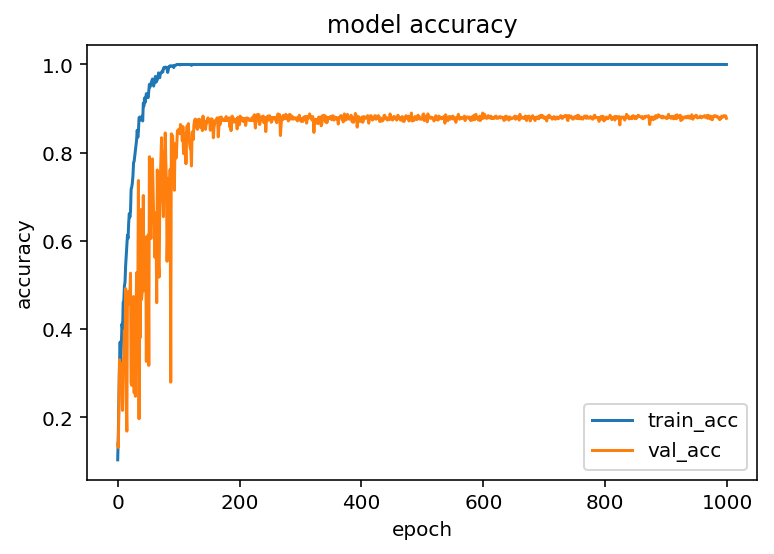

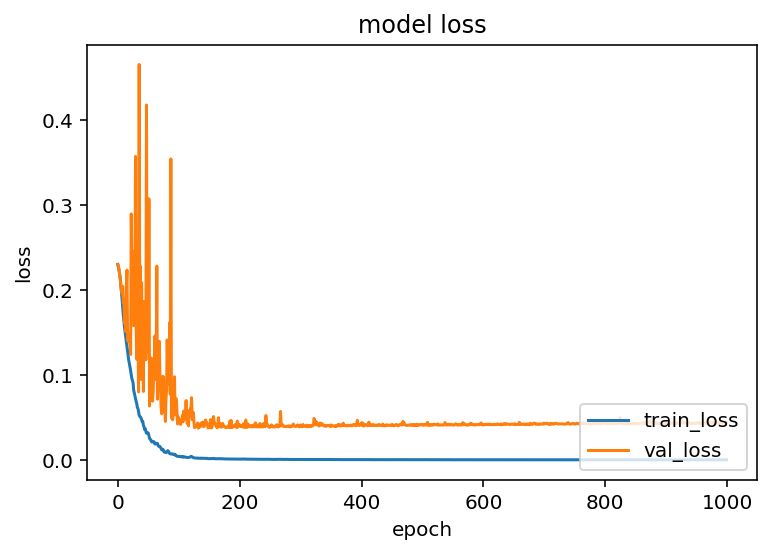

In [430]:
model = Net()
if use_gpu:
    model.cuda()

def save_checkpoint(state, filename='./save/checkpoint_{}.pth'.format(ex_name)):
    torch.save(state, filename)
    #shutil.copyfile(filename, 'model_best.pth.tar')
    
criterion = nn.KLDivLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
tracker = TrainingTracker()

for epoch in range(0, epochs):
    tracker.epoch = epoch
    
    _train(model, train_loader, criterion, optimizer, tracker)
    _validate(model, val_loader, criterion, tracker)
    
    # if latest accuracy is the best in history
    if np.argmax(tracker.history['val_acc']) == len(tracker.history['val_acc']) - 1:
        save_checkpoint({
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),
        })
    
logger.info('Train done.')
tracker.plot_history()

# Make Pseudo Label

In [433]:
model = Net()
resume = torch.load('./save/checkpoint_{}.pth'.format(ex_name))
model.load_state_dict(resume['state_dict'])
_test(model, test_loader, criterion, make_pl=True)

100%|██████████| 266/266 [00:14<00:00, 18.98it/s]
[2017-12-02 14:19:45,805 INFO] TestAcc: 0.8919 |TestLoss: 0.0392 
